# Семинар № 11 - VAE

# Imports 

In [ ]:
# !pip install -q -U albumentations
# !pip install --upgrade -q albumentations==0.4.6
# !echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 117 kB 5.4 MB/s 
     |████████████████████████████████| 948 kB 43.0 MB/s 
albumentations==0.4.6 is successfully installed


In [2]:
import os
from pathlib import Path
import random
import typing as tp
from time import gmtime, strftime

import yaml
from tqdm import tqdm
from cv2 import erode
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import rotate, rescale, resize


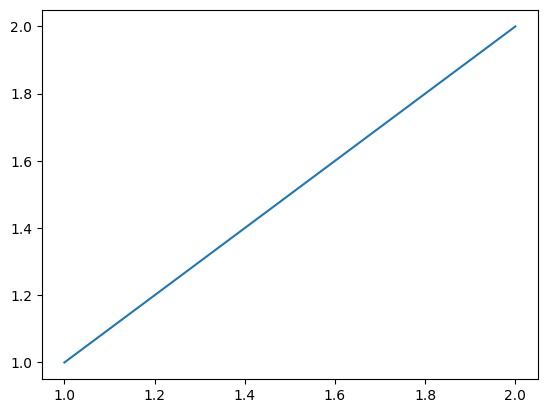

In [3]:
plt.plot([1,2], [1,2])

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [5]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [6]:
set_seed(42)

DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# DEVICE = torch.device('cpu')

# Набор данных


In [7]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_validset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [8]:
len(mnist_trainset), len(mnist_validset)

(60000, 10000)

In [9]:
img, label = mnist_trainset[4]

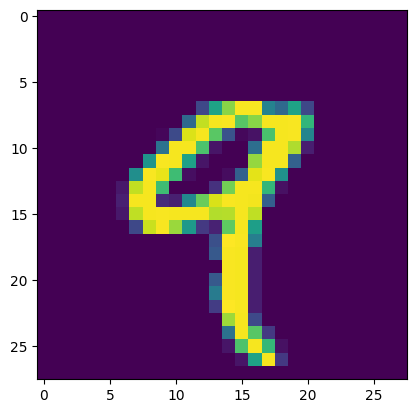

In [10]:
plt.imshow(np.array(img))

## Create dataset

In [11]:
class MNISTDataset(Dataset):
    def __init__(self, data,
                 transforms: tp.Optional[A.BasicTransform] = None):
        self.data = data
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> dict:
        image, label = self.data[idx]
        image = np.array(image)
        
        # check for dimensions            
        if image.ndim == 2:
            image = image[..., np.newaxis]
            
        result = {"image": image}

        if self.transforms is not None:
            result = self.transforms(**result)
            
        image = result['image']
        label = torch.tensor(label).long()

        return image, label

## Create augs

In [12]:
def pre_transform() -> A.BasicTransform:
    result = []
    return A.Compose(result)


def augmentations() -> A.BasicTransform:
    result = [
        # A.GaussNoise(),
    ]
    return A.Compose(result)


def post_transform() -> A.BasicTransform:
    return A.Compose([
        A.Normalize(mean=0, 
                    std=1,
                    max_pixel_value=255),
        ToTensorV2()
    ])

In [13]:
# Create train pipeline
train_transformation = A.Compose([
    pre_transform(), augmentations(), post_transform()
])


# Create valid pipeline
valid_transformation = A.Compose([
    pre_transform(), post_transform()
])  

### Check augs

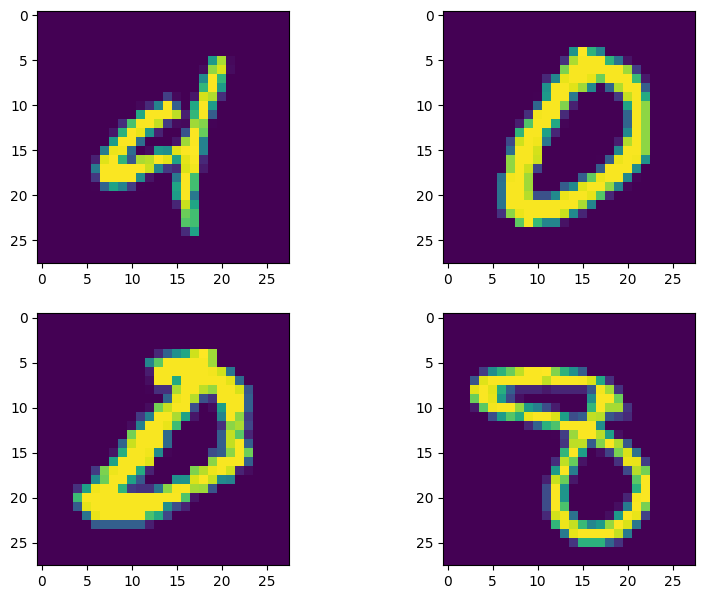

In [14]:
_, ax = plt.subplots(2, 2, figsize=(6.4 * 1.5, 4.8 * 1.5))

for i in range(4):
    sample_idx = np.random.randint(0, len(mnist_trainset), 1)[0]
    sample_image, _ = mnist_trainset[sample_idx]
    sample_image = np.array(sample_image)[..., np.newaxis]
    aug_image = train_transformation(image=sample_image)["image"].numpy()
    ax[i % 2][i // 2].imshow(aug_image[0])
    
plt.show()

## Make DataLoader 

In [15]:
batch_size = 128
num_workers = 0  # num_workers = 0 for local notebook on win 

train_dataset = MNISTDataset(mnist_trainset, train_transformation)
train_loader = DataLoader(
    train_dataset, 
    shuffle=True,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
)

valid_dataset = MNISTDataset(mnist_validset, valid_transformation) 
valid_loader = DataLoader(
    valid_dataset, 
    shuffle=False,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
)

In [16]:
image, label = next(iter(train_loader))

print('Image batch shape:', image.shape)

Image batch shape: torch.Size([128, 1, 28, 28])


# Create model 

In [17]:
class Encoder(nn.Module):
    def __init__(self, latent_size: int = 2):
        super().__init__()
        self.latent_size = latent_size

        # Create encoder model
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Flatten()
        )
        self.fc_mean = nn.Linear(128, latent_size)
        self.fc_var = nn.Linear(128, latent_size)
        
    def forward(self, images: torch.Tensor) -> tp.Tuple[torch.Tensor, torch.Tensor]:
        features = self.feature_extractor(images)
        mean = self.fc_mean(features)
        log_var = self.fc_var(features)

        return mean, log_var

In [18]:
class Decoder(nn.Module):
    def __init__(self, latent_size: int = 2):
        super().__init__()
        self.latent_size = latent_size

        # Create Decoder model!
        self.map_generator = nn.Sequential(
            nn.Linear(latent_size, 128 * 49),
        )
        self.deconv = nn.Sequential(
            self.make_up_layer_(128, 64), # 7 -> 14
            self.make_up_layer_(64, 16), # 14 -> 28
        )
        self.output = nn.Sequential(
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Tanh()
        )
        
    def make_up_layer_(self, in_channels: int, out_channels: int) -> torch.Tensor:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 
                               kernel_size=3, padding=1,
                               output_padding=1, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(0.1),
            nn.LeakyReLU(0.01)
        )
            
    def forward(self, points: torch.Tensor) -> torch.Tensor:
        feature_map = self.map_generator(points)
        feature_map = feature_map.view(feature_map.size(0), -1, 7, 7)
        
        feature_map = self.deconv(feature_map)
        
        return self.output(feature_map)

In [19]:
LOG_SCALE_MAX = 2
LOG_SCALE_MIN = -10

def normal_sample(loc: torch.Tensor, log_scale: torch.Tensor) -> torch.Tensor:
    scale = torch.exp(0.5 * log_scale)
    return loc + scale * torch.randn_like(scale)


class VAE(nn.Module):
    def __init__(self, latent_size: int = 2):
        super().__init__()

        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)
        
    def forward(self, x: torch.Tensor):
        mean, log_var = self.encoder(x)  # get mean and log_var for sampling
        log_var = torch.clamp(log_var, LOG_SCALE_MIN, LOG_SCALE_MAX)

        z_ = normal_sample(mean, log_var) if self.training else mean
        x_ = self.decoder(z_)  # recreate object from z_

        return x_, mean, log_var

In [20]:
latent_size = 16
model = VAE(latent_size).to(DEVICE)

In [21]:
x = torch.ones((256, 1, 28, 28)).to(DEVICE)

x_hat, mean, log_var = model(x)

In [22]:
x_hat.shape, mean.shape, log_var.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256, 16]), torch.Size([256, 16]))

## Define loss

In [23]:
BCE_loss = nn.BCELoss()

def KLD_loss(mean, log_var):
     return (-0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1)).mean()

In [24]:
KLD_loss(mean, log_var)

tensor(23.2205, device='cuda:0', grad_fn=<MeanBackward0>)

In [25]:
BCE_loss(x_hat.sigmoid(), x)

tensor(0.6375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [26]:
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)

## Train loop

In [27]:
epochs = 2

In [28]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (x, _) in pbar:
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss_bce = BCE_loss(x_hat.sigmoid(), x)
        loss_kld = KLD_loss(mean, log_var)
        loss = loss_bce + loss_kld
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()

        log_line = f'Loss: {loss.detach().cpu().data:.4f}'
        pbar.set_description(log_line)

        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx * batch_size))
    
print("Finish!!")

Start training VAE...


Loss: 0.4524: 100%|██████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 65.72it/s]


	Epoch 1 complete! 	Average Loss:  0.005219700922232273


Loss: 0.4386: 100%|██████████████████████████████████████████████████████████████████| 468/468 [00:07<00:00, 64.71it/s]

	Epoch 2 complete! 	Average Loss:  0.003493251839385426
Finish!!


## Generate images

In [29]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(valid_loader):
        x = x.to(DEVICE)
    
        x_hat, _, _ = model(x)

        break

In [30]:
def show_image(x, idx):

    fig = plt.figure()
    plt.imshow(x[idx][0].cpu().numpy())

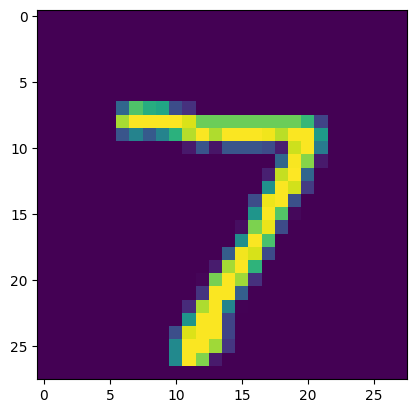

In [31]:
show_image(x, idx=0)

In [47]:
with torch.no_grad():
    noise = torch.randn(24, latent_size).to(DEVICE)
    generated_images = model.decoder(noise)

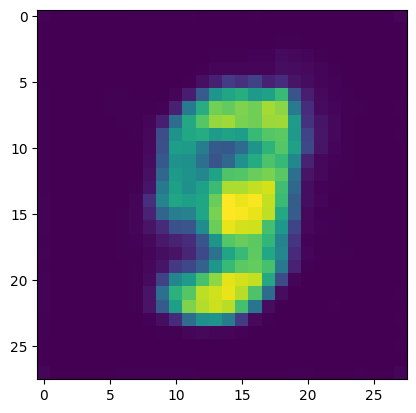

In [48]:
show_image(generated_images, idx=0)

In [45]:
with torch.no_grad():
    noise = torch.randn(12, 1, 28, 28).to(DEVICE)
    generated_images, _, _ = model(noise)

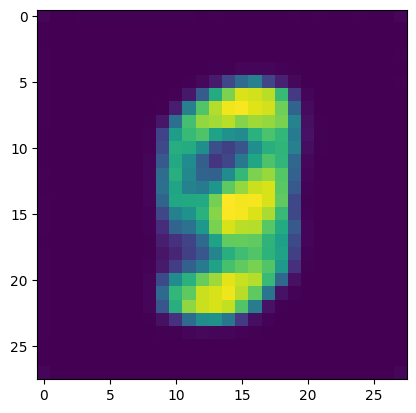

In [46]:
show_image(generated_images, idx=4)